In [3]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [4]:
station_day = pd.read_csv("station_day.csv")

In [5]:
station_day.head(3)

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate


In [6]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


In [7]:
arima_df = station_day[['Date','AQI']]

In [8]:
arima_df["Date"]= pd.to_datetime(arima_df["Date"])

In [9]:
arima_df.AQI = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [10]:
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].mean()

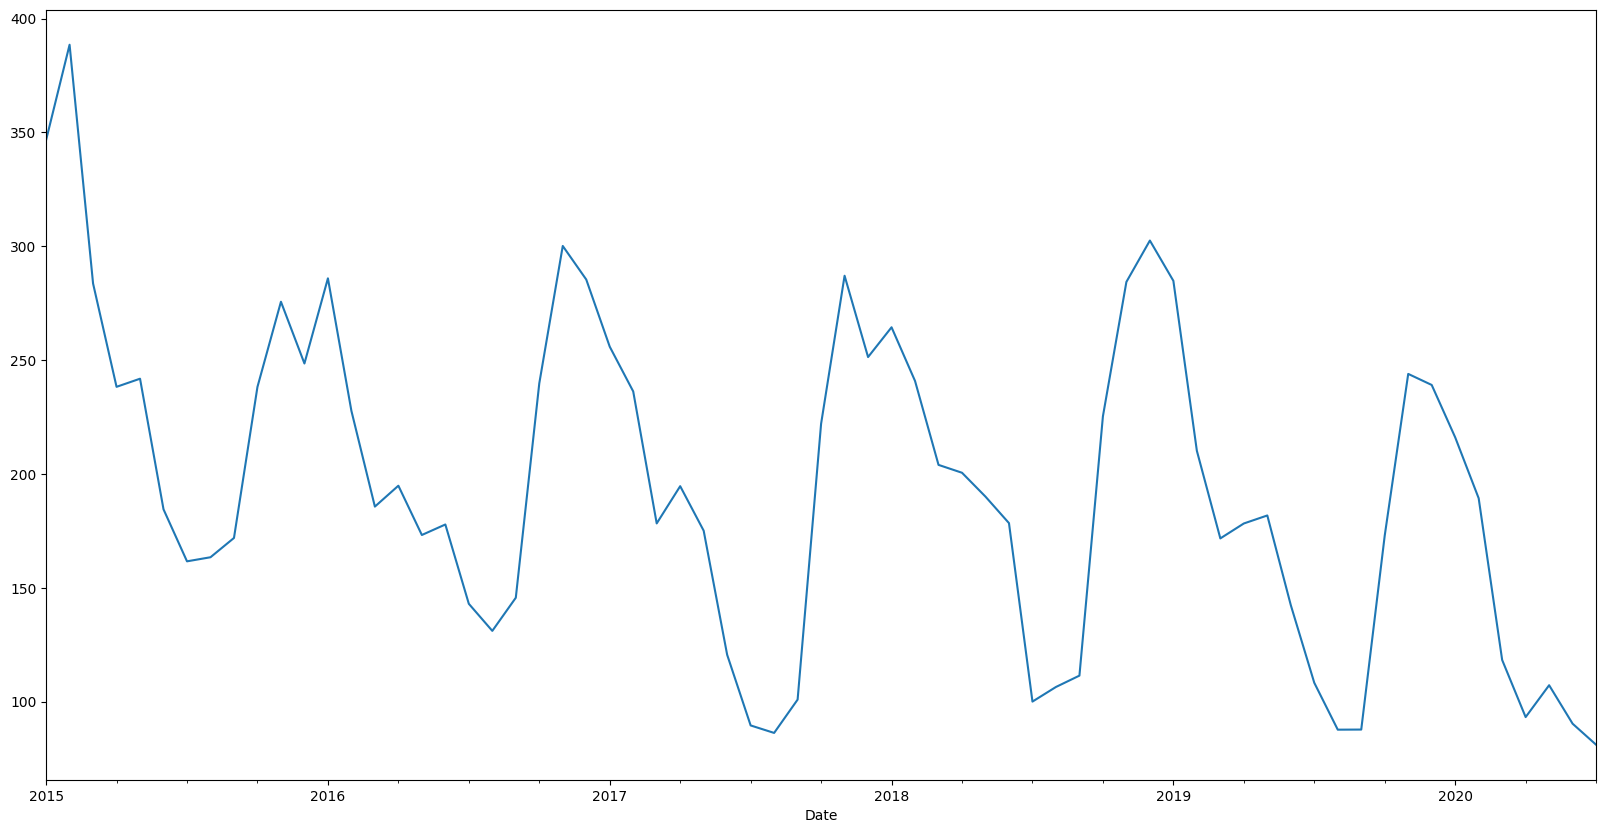

In [11]:
plt.figure(figsize = (20,10))
ts.plot()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.224505
p-value: 0.662967


In [13]:
ts_train = ts[:50]
ts_test = ts[50:]

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
import itertools
from sklearn.metrics import mean_squared_error

In [16]:
p = range(0,8)
q = range(0,8)
d = range(0,2)

In [17]:
pqd_combination = list(itertools.product(p,d,q))

In [18]:
error = []
pqd = []

In [19]:
for i in pqd_combination:
    A_model = ARIMA(ts_train,order= i).fit()
    predict = A_model.predict(len(ts_train),len(ts)-1)
    e = np.sqrt(mean_squared_error(ts_test,predict))
    pqd.append(i)
    error.append(e)

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

In [20]:
min = error[0]
index = 0
for i in range(1,len(error)-1):
    if(min > error[i]):
        min = error[i]
        index = i
        
print(error[index],' => ',pqd[index])

48.48382894994655  =>  (7, 1, 1)


In [21]:
model_ts = ARIMA(ts_train, order=pqd[index])
model_ts_fit = model_ts.fit()
print(model_ts_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   50
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -241.966
Date:                Sun, 16 Oct 2022   AIC                            501.931
Time:                        21:44:41   BIC                            518.957
Sample:                    01-31-2015   HQIC                           508.391
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7066      0.217      3.257      0.001       0.281       1.132
ar.L2         -0.2553      0.247     -1.036      0.300      -0.739       0.228
ar.L3         -0.1310      0.188     -0.697      0.4

In [22]:
arima_predict = model_ts_fit.predict(start = len(ts_train),end = len(ts))

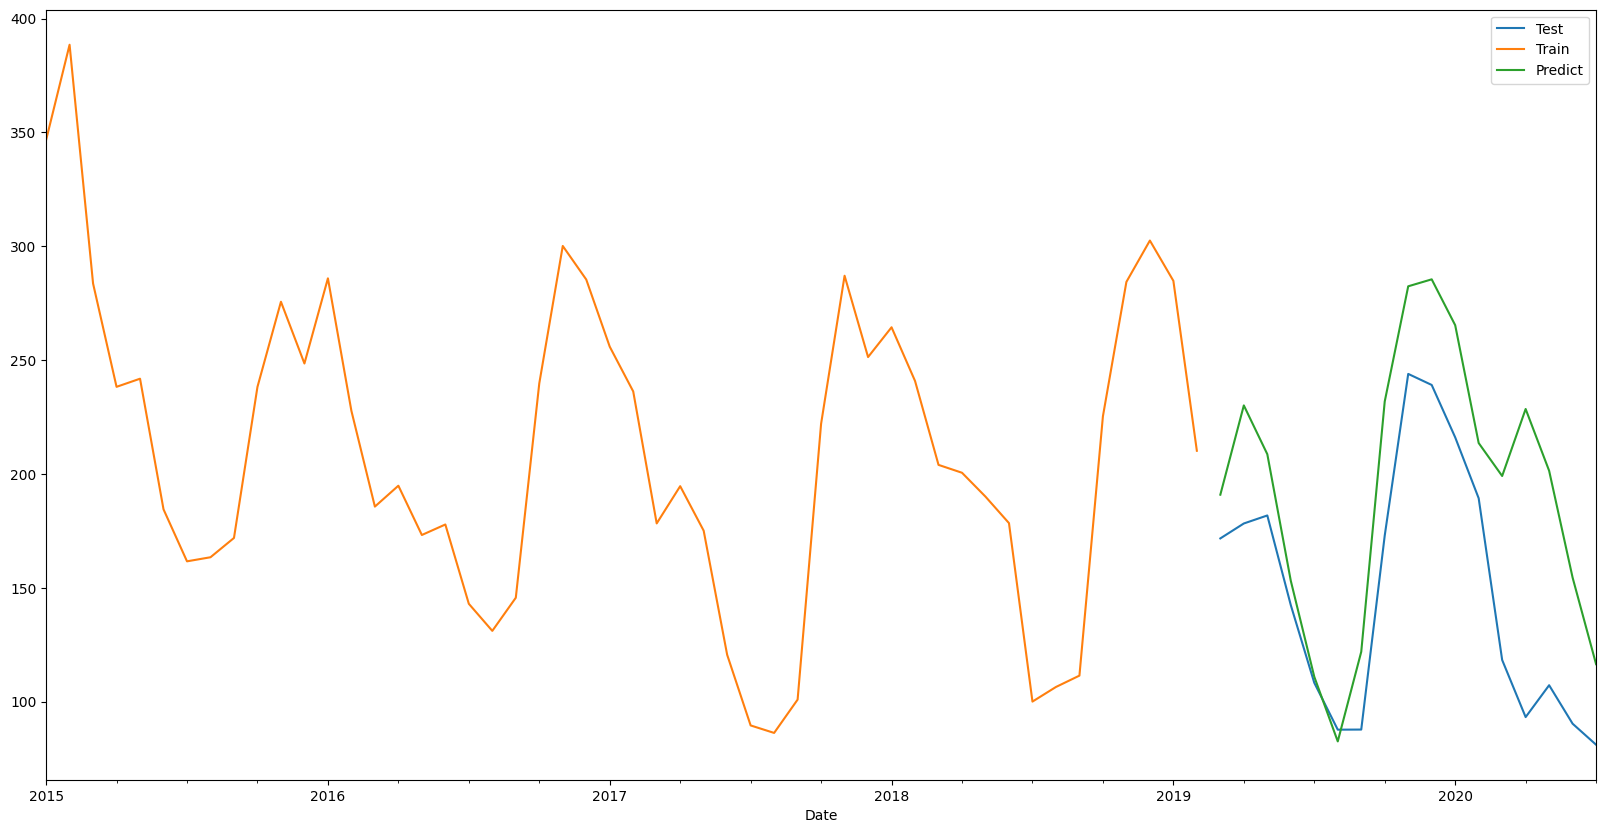

In [23]:
plt.figure(figsize = (20,10))
ts_test.plot(label = "Test")
ts_train.plot(label = "Train")
predict.plot(label = 'Predict')
plt.legend()
plt.show()

In [24]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                 -1.224505
p-value                         0.662967
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [25]:
df1_ts = ts - ts.shift(1)

In [26]:
df1_ts=df1_ts.dropna()

In [27]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df1_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                -7.389944e+00
p-value                        8.050075e-11
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


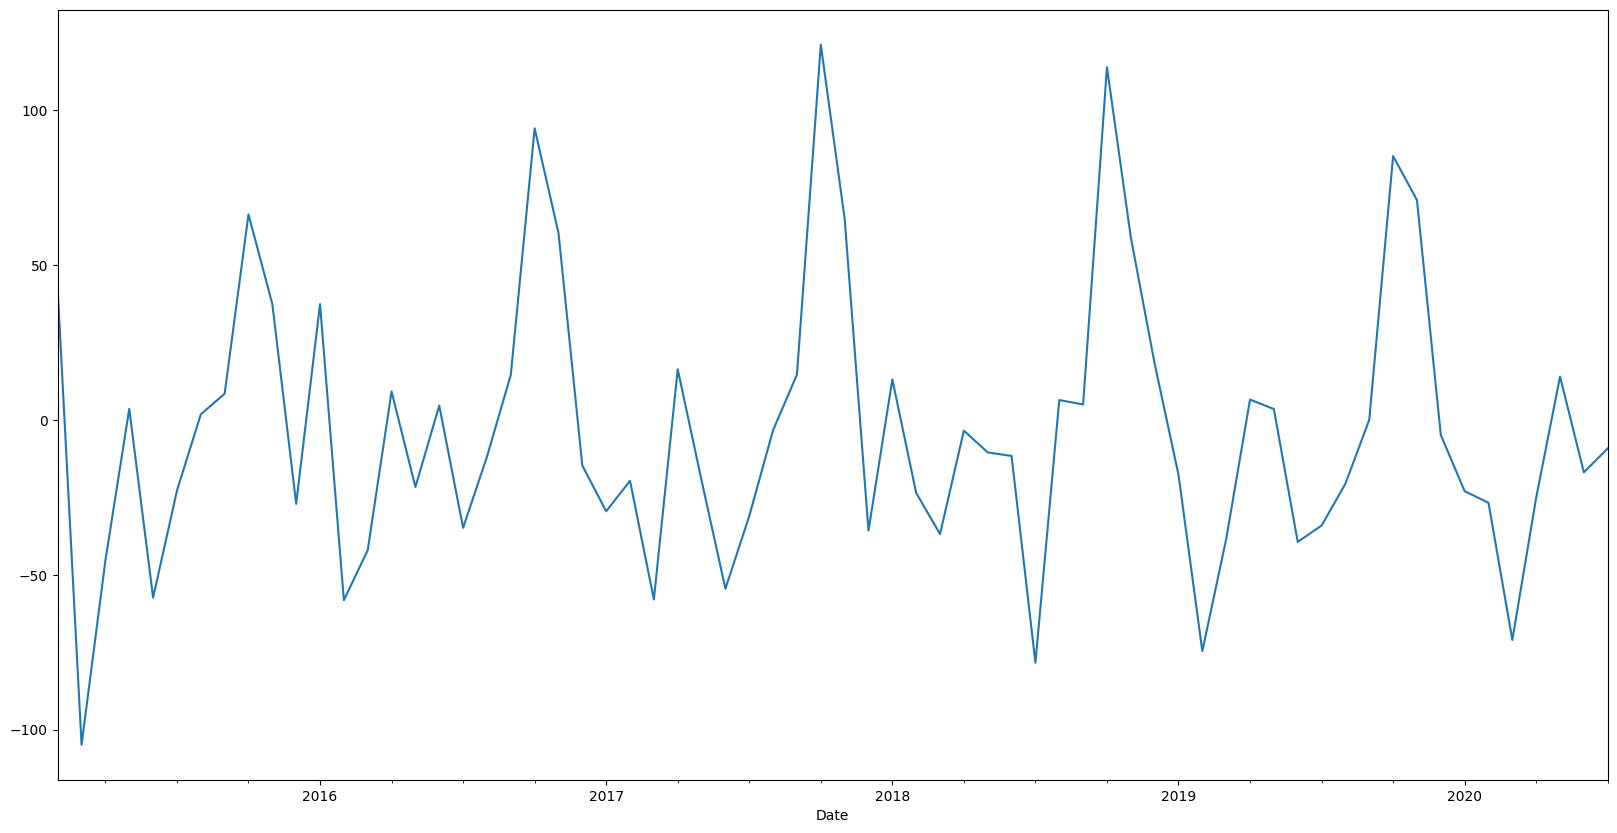

In [28]:
plt.figure(figsize = (20,10))
df1_ts.plot()
plt.show()

In [29]:
df1_ts_train = df1_ts[:50]
df1_ts_test = df1_ts[50:]

In [30]:
df_pdq = []
df_error = []

In [31]:
for i in pqd_combination:
    A_model = ARIMA(df1_ts_train,order= i).fit()
    predict = A_model.predict(len(df1_ts_train),len(df1_ts)-1)
    e = np.sqrt(mean_squared_error(df1_ts_test,predict))
    df_pdq.append(i)
    df_error.append(e)

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

In [32]:
min = df_error[0]
index = 0
for i in range(1,len(df_error)-1):
    if(min > df_error[i]):
        min = df_error[i]
        index = i
        
print(df_error[index],' => ',df_pdq[index])

20.36012104806701  =>  (5, 0, 7)


In [33]:
import statsmodels.api as sm

In [34]:
sarima_model = sm.tsa.statespace.SARIMAX(df1_ts_train, trend='n', order=(7,0,3), seasonal_order=(1,1,1,12))
s_results = sarima_model.fit()
print(s_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   50
Model:             SARIMAX(7, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -176.699
Date:                              Sun, 16 Oct 2022   AIC                            379.398
Time:                                      21:45:36   BIC                            400.686
Sample:                                  02-28-2015   HQIC                           386.972
                                       - 03-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2079      1.962     -0.106      0.916      -4.054       3.638
ar.L2         -0.99

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
s_pred = s_results.predict(start = len(df1_ts_train),end = len(df1_ts)-1)

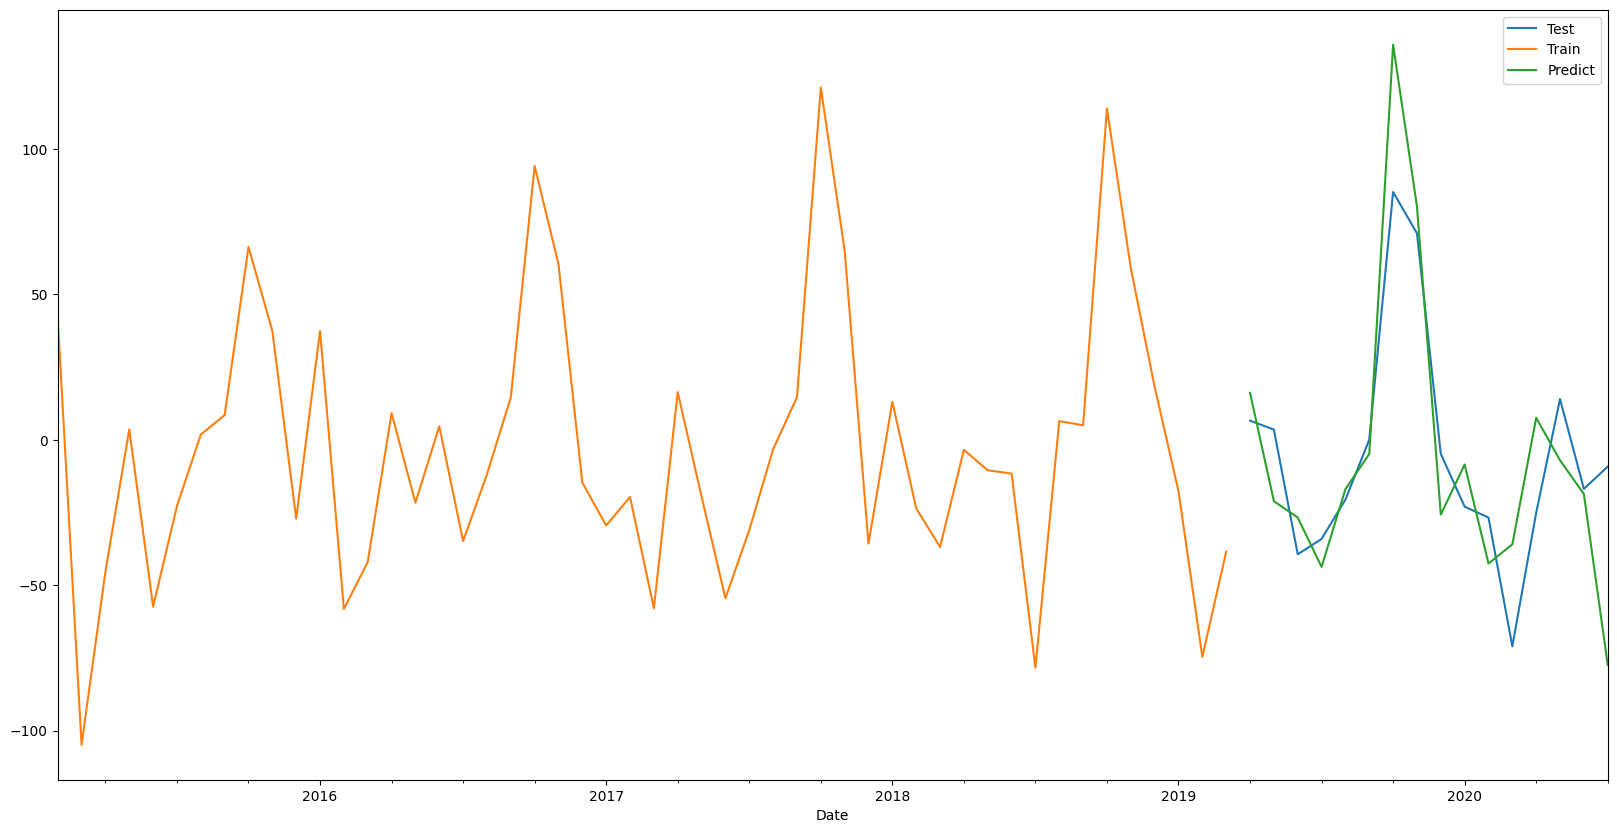

In [36]:
plt.figure(figsize = (20,10))
df1_ts_test.plot(label = "Test")
df1_ts_train.plot(label = "Train")
s_pred.plot(label = 'Predict')
plt.legend()
plt.show()


In [37]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [38]:
alt_fb_df = station_day[['Date','AQI']]

In [39]:
alt_fb_df["Date"]= pd.to_datetime(alt_fb_df["Date"])

In [40]:
alt_fb_df.AQI = alt_fb_df.groupby(pd.PeriodIndex(alt_fb_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [41]:
alt_fb_df = alt_fb_df.rename(columns={'Date':'ds','AQI':'y'})

In [42]:
alt_fb_df_train = alt_fb_df[:-26108]
alt_fb_df_test = alt_fb_df[len(alt_fb_df)-26108:]

In [45]:
pip install Prophet

Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install fbprophet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Asus\AppData\Local\Temp\pip-install-gfxx5d5h\pystan_24bd323ce7734453891b469f4d238774\setup.py", line 122, in <module>
          from Cython.Build.Inline import _get_build_extension
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.



     ---------------------------------------- 64.0/64.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 986.3/986.3 kB 5.2 MB/s eta 0:00:00
     -------------------------------------- 411.7/411.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 91.8/91.8 kB 5.1 MB/s eta 0:00:00
     -------------------------------------- 319.7/319.7 kB 4.9 MB/s eta 0:00:00
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


NameError: name 'alt_forecast' is not defined

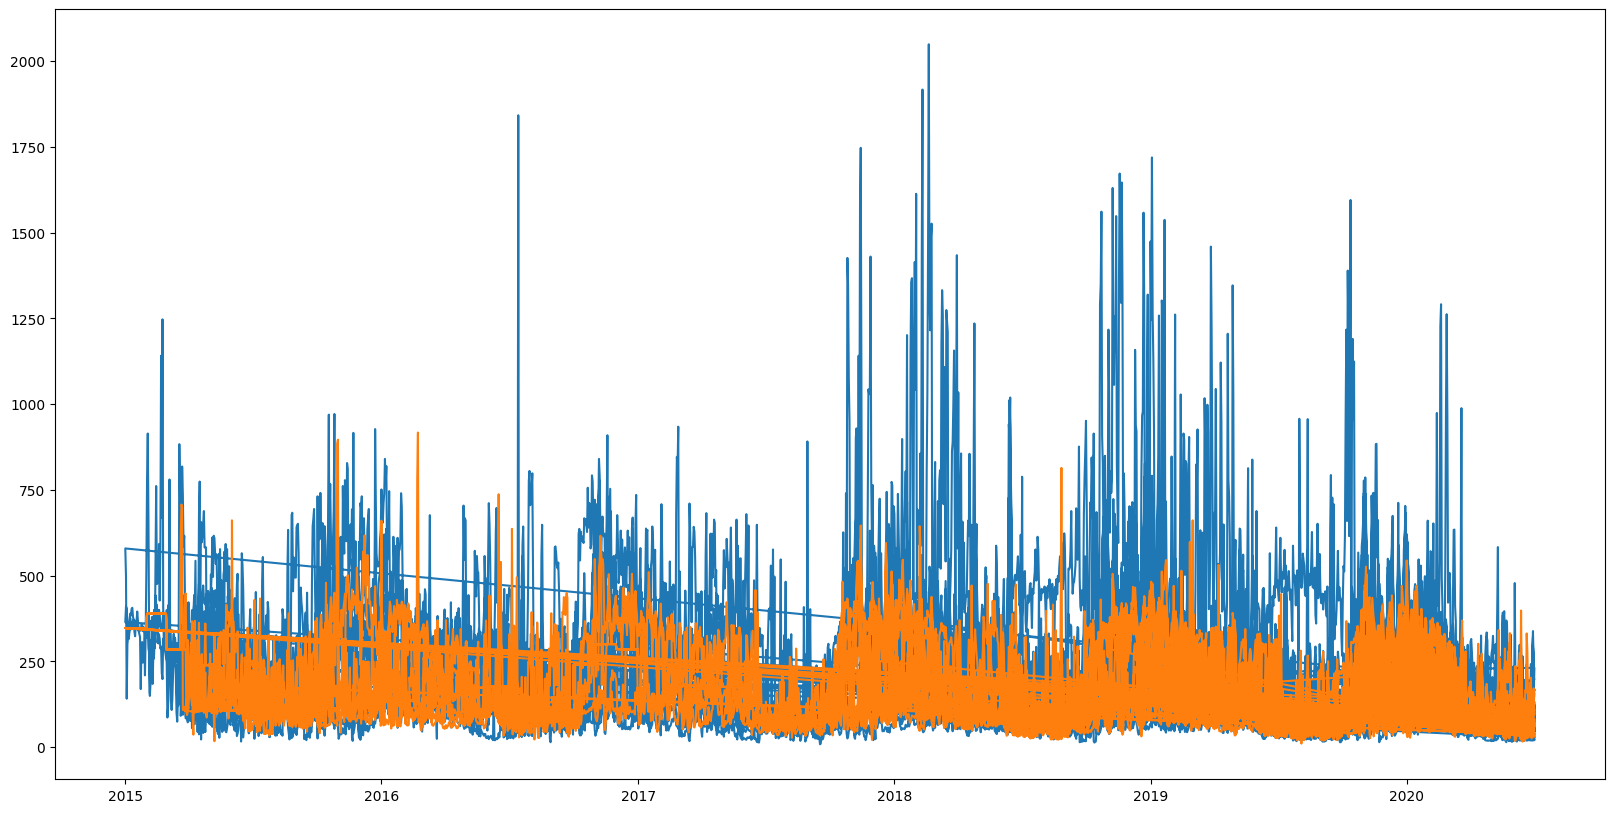

In [59]:
plt.figure(figsize = (20,10))
plt.plot(alt_fb_df_train['ds'],alt_fb_df_train['y'],label = "Train")
plt.plot(alt_fb_df_test['ds'],alt_fb_df_test['y'],label = "Test")
plt.plot(alt_forecast['ds'],alt_forecast['yhat'],label = 'Predict')
plt.legend()
plt.show()

In [62]:
lstm_df = station_day

In [63]:
lstm_df["Date"]= pd.to_datetime(lstm_df["Date"])

In [64]:
lstm_df.drop(['AQI_Bucket', 'StationId'], axis=1, inplace=True)

In [65]:
lstm_df=lstm_df.dropna()

In [66]:
lstm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 1 to 106147
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     10314 non-null  datetime64[ns]
 1   PM2.5    10314 non-null  float64       
 2   PM10     10314 non-null  float64       
 3   NO       10314 non-null  float64       
 4   NO2      10314 non-null  float64       
 5   NOx      10314 non-null  float64       
 6   NH3      10314 non-null  float64       
 7   CO       10314 non-null  float64       
 8   SO2      10314 non-null  float64       
 9   O3       10314 non-null  float64       
 10  Benzene  10314 non-null  float64       
 11  Toluene  10314 non-null  float64       
 12  Xylene   10314 non-null  float64       
 13  AQI      10314 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.2 MB


In [67]:
dates = lstm_df['Date']
lstm_df.drop('Date', axis=1,inplace=True)

In [68]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

col_names = []
for i in lstm_df.columns:
    col_names.append(i)

lstm_df[col_names] = min_max_scaler.fit_transform(lstm_df[col_names])

In [69]:
x = lstm_df.drop(columns =['AQI'])
y = lstm_df['AQI']

In [70]:
x.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
count,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000
mean,0.070067,0.124616,0.046511,0.130229,0.090175,0.063002,0.147519,0.146026,0.198364,0.026781,0.046792,0.021425
std,0.058763,0.082347,0.072069,0.089924,0.085037,0.047205,0.092177,0.118020,0.122841,0.081127,0.091783,0.052759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033607,0.069053,0.010039,0.059701,0.038192,0.034216,0.088608,0.063580,0.113062,0.001390,0.005366,0.000898
50%,0.057685,0.112861,0.023857,0.112101,0.067817,0.050958,0.132911,0.115545,0.173814,0.009189,0.019341,0.006587
75%,0.088783,0.160212,0.051187,0.181183,0.110580,0.081051,0.189873,0.189250,0.254960,0.025150,0.048131,0.022081
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
dates = np.array(dates)
dates

array(['2017-11-25T00:00:00.000000000', '2017-11-26T00:00:00.000000000',
       '2017-11-27T00:00:00.000000000', ...,
       '2020-02-12T00:00:00.000000000', '2020-02-13T00:00:00.000000000',
       '2020-02-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [72]:
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [73]:
y = np.array(y)
y = y.reshape(-1,)

In [74]:
dates_train, x_train, y_train = dates[:1500], x[:1500], y[:1500]
dates_test, x_test, y_test = dates[1500:], x[1500:], y[1500:]

In [75]:
x_train.shape

(1500, 12, 1)

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import InputLayer

model_lstm = Sequential()

model_lstm.add(InputLayer((12,1)))

model_lstm.add(LSTM(50))

model_lstm.add(Dense(34 ,'relu'))
# model_lstm.add(Dropout(0.25))

model_lstm.add(Dense(15 ,'relu'))

model_lstm.add(Dense(1 ,'relu' ))

In [77]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 34)                1734      
                                                                 
 dense_1 (Dense)             (None, 15)                525       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12,675
Trainable params: 12,675
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_lstm.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [79]:
lstm_history = model_lstm.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

Epoch 1/10
32/32 [==============================] - 4s 17ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.0000e+00 - val_los

In [80]:
lstm_y_pred = model_lstm.predict(x_test)

276/276 [==============================] - 1s 2ms/step


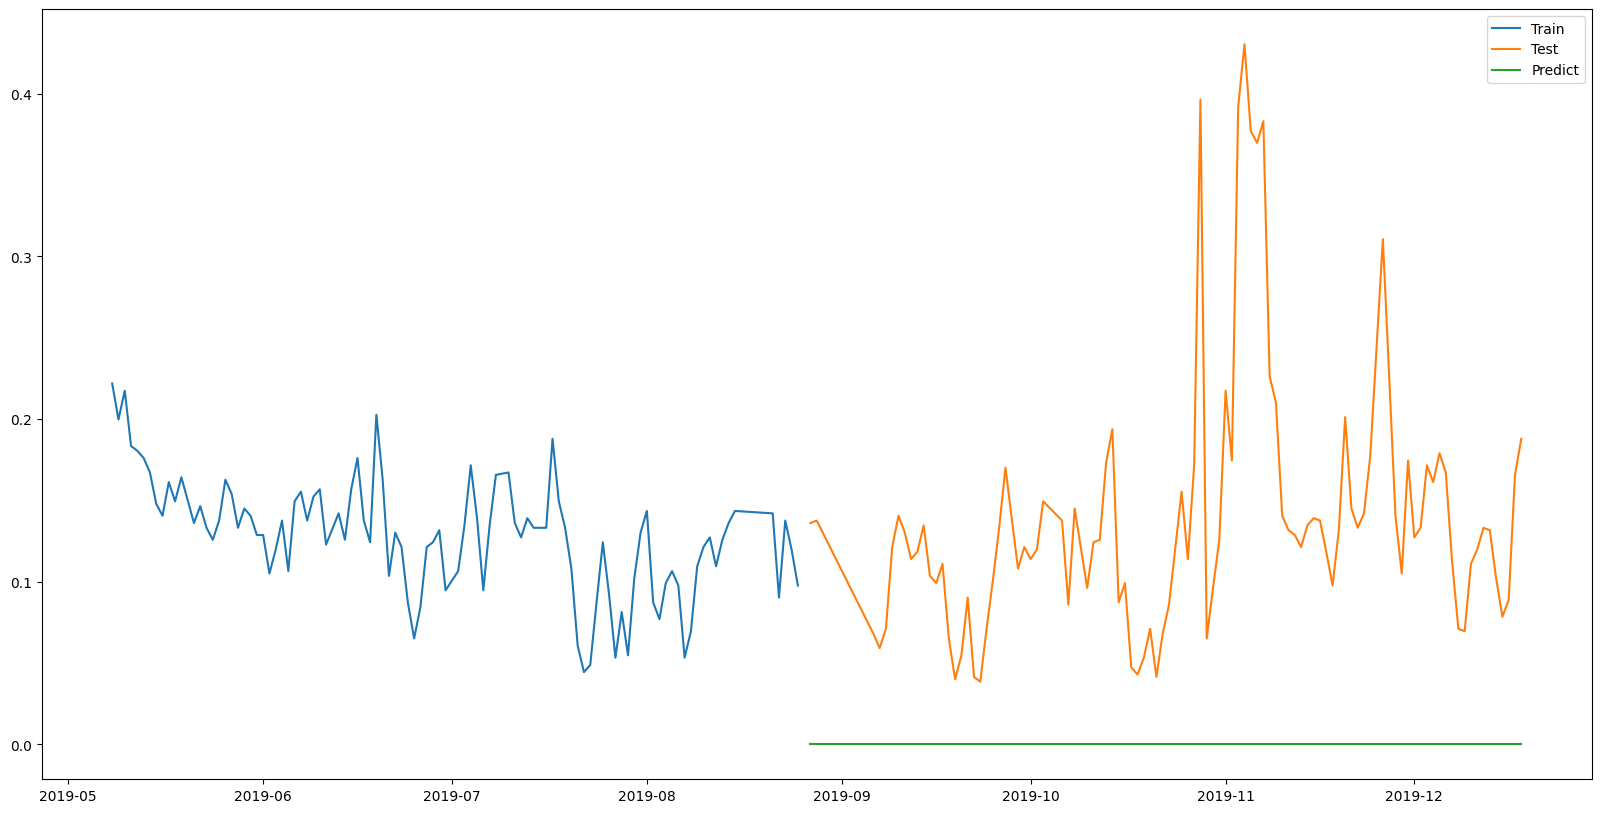

In [81]:
plt.figure(figsize = (20,10))
plt.plot(dates_train[-100:],y_train[-100:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],lstm_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()

In [82]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import InputLayer

model_gru = Sequential()

model_gru.add(InputLayer((12,1)))

model_gru.add(GRU(50))

model_gru.add(Dense(26 ,'relu'))
# model_lstm.add(Dropout(0.25))

model_gru.add(Dense(10 ,'relu'))

model_gru.add(Dense(1 ))

In [83]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense_3 (Dense)             (None, 26)                1326      
                                                                 
 dense_4 (Dense)             (None, 10)                270       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,557
Trainable params: 9,557
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_gru.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [85]:
gru_history = model_gru.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

Epoch 1/10
32/32 [==============================] - 2s 16ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_los

In [86]:
model_gru.evaluate(x_test, y_test)

276/276 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.1346e-04


[0.0033630782272666693, 0.00011345586244715378]

In [87]:
gru_y_pred = model_gru.predict(x_test)

276/276 [==============================] - 1s 1ms/step


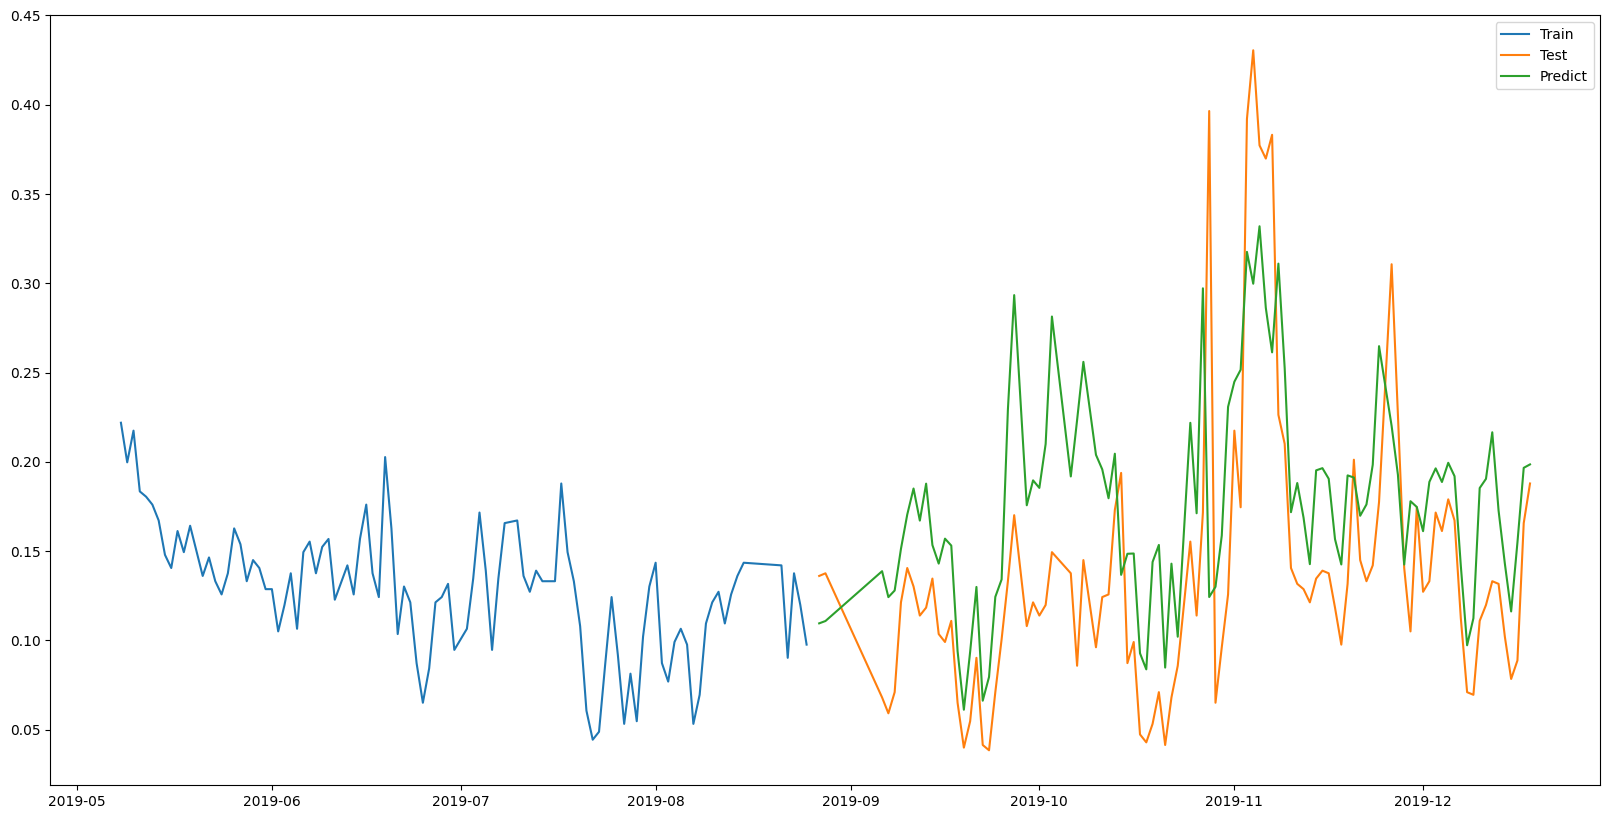

In [88]:
plt.figure(figsize = (20,10))
plt.plot(dates_train[-100:],y_train[-100:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],gru_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()